#  序列到序列学习（seq2seq）



In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

实现循环神经网络编码器

In [2]:
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        '''
        super(Seq2SeqEncoder, self)获取Seq2SeqEncoder的父类（即d2l.Encoder）
        .__init__(**kwargs)调用父类的构造函数
        **kwargs将所有关键字参数原样传递给父类
        '''
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        '''
        嵌入层：将离散的词索引（大小为vocab_size）映射为密集向量（维度为embed_size）。
        输入形状：(batch_size,seq_len)（词索引序列）
        输出形状：(batch_size,seq_len,embed_size)（嵌入向量序列）
        '''
        self.embedding = nn.Embedding(vocab_size, embed_size)
        '''
        GRU层：处理嵌入序列
        embed_size: 输入特征维度（嵌入层输出）
        num_hiddens: 隐藏单元数量（GRU输出的维度）
        num_layers: GRU层数（堆叠层数）
        dropout: 在多层GRU中，层间的Dropout比率（除最后一层外）
        '''
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 将输入的词索引张量转换为嵌入向量。形状变化：(batch_size,seq_len)→(batch_size,seq_len,embed_size)
        X = self.embedding(X) # 第一步：词索引 → 嵌入向量
        # PyTorch的GRU要求输入形状为(seq_len,batch_size,input_size)（时间步优先）
        # 将batch_size和seq_len 交换位置
        # 形状变化：(batch_size,seq_len,embed_size)→(seq_len,batch_size,embed_size)
        X = X.permute(1, 0, 2) # 第二步：调整维度顺序
        # output: 所有时间步的隐藏状态，形状(seq_len,batch_size,num_hiddens)
        # state: 最后时间步的隐藏状态，形状(num_layers,batch_size,num_hiddens)
        # 若为双向GRU，则形状为(num_layers*2,batch_size,num_hiddens)
        output, state = self.rnn(X) # 第三步：经过GRU处理
        # output用于后续注意力机制或解码器;state作为解码器的初始隐藏状态
        return output, state # 第四步：返回结果

上述编码器的实现

| 数据类型                   | 适用场景     | Embedding层支持     |
| ---------------------- | -------- | ---------------- |
| `torch.long` | 词索引、类别标签 | ✅  必需    |
| `torch.float32`        | 模型权重、特征  | ❌  报错    |
| `torch.int32`          | 普通整数计算   | ⚠️  不推荐  |


In [3]:
'''
词汇表大小：10（支持0-9共10个词索引）
嵌入维度：8（每个词被编码为8维向量）
GRU隐藏单元：16
GRU层数：2层堆叠
'''
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
'''
设置为评估模式
关闭 Dropout 等训练时特有的随机性操作
保持模型参数不变，确保输出确定性（常用于验证或测试）
'''
encoder.eval()
'''
批量大小：4（4个独立样本）
序列长度：7（每个样本包含7个词）
数据类型：torch.long（整数索引，符合嵌入层输入要求）
初始值：全0（模拟4个长度为7的"全填充"序列）
'''
X = torch.zeros((4, 7), dtype=torch.long)
# 输入X形状：(4,7)→经过编码器处理
output, state = encoder(X)
'''
7：序列长度（seq_len），每个时间步输出一个隐藏状态
4：批量大小（batch_size）
16：隐藏单元数（num_hiddens），即每个时间步的特征维度
'''
output.shape

torch.Size([7, 4, 16])

In [4]:
state.shape

torch.Size([2, 4, 16])

解码器

| 步骤 | 操作       | 关键变化                                                             |
| -- | -------- | ---------------------------------------------------------------- |
| 1  | 嵌入 + 置换  | `(batch, seq)` → `(seq, batch, embed)`                           |
| 2  | 复制上下文    | `(batch, hidden)` → `(seq, batch, hidden)`                       |
| 3  | 拼接       | `(seq, batch, embed+hidden)`                                     |
| 4  | GRU      | `output: (seq, batch, hidden)`, `state: (layers, batch, hidden)` |
| 5  | 全连接 + 置换 | `(batch, seq, vocab)`                                            |


In [5]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    # __init__方法（初始化）
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs) # 继承父类d2l.Decoder的初始化
        # 嵌入层：将目标语言的词索引映射为向量（维度embed_size）
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # GRU层：输入维度是embed_size+num_hiddens,
        # 多出的num_hiddens用于拼接上下文向量（编码器最后时刻的隐藏状态），帮助解码器聚焦源序列信息
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        # 全连接层：将GRU输出映射到词汇表大小，生成每个词的预测概率分布
        self.dense = nn.Linear(num_hiddens, vocab_size)
    # init_state方法（状态初始化）
    def init_state(self, enc_outputs, *args):
        # 从编码器输出中提取最后隐藏状态（即enc_outputs[1]）作为解码器的初始状态,实现了编码器→解码器的信息传递
        return enc_outputs[1]
    # 前向传播
    def forward(self, X, state):
        # 嵌入+维度置换：输入X形状(batch,seq_len)→嵌入后(batch,seq_len,embed)→置换为 (seq_len,batch,embed)
        X = self.embedding(X).permute(1, 0, 2)
        # 上下文向量：取state的最后一层（state[-1]），形状(batch,num_hiddens)
        # 复制扩展：repeat将context在时间步维度上复制seq_len次，变为(seq_len,batch,num_hiddens)，使其能与X拼接
        context = state[-1].repeat(X.shape[0], 1, 1)
        # 拼接：在特征维度（dim=2）上合并词嵌入和上下文向量
        # 形状：(seq_len,batch,embed_size+num_hiddens)，作为GRU的输入
        X_and_context = torch.cat((X, context), 2)
        # output: 所有时间步隐藏状态，形状(seq_len,batch,num_hiddens)
        # state: 最后隐藏状态，形状(num_layers,batch,num_hiddens)
        output, state = self.rnn(X_and_context, state)
        '''
        预测+维度恢复：
        dense: 将隐藏状态映射为词汇表大小的logits，形状 (seq_len,batch,vocab_size)
        permute: 转回(batch,seq_len,vocab_size)，便于后续计算损失
        '''
        output = self.dense(output).permute(1, 0, 2)
        return output, state

实例化解码器

In [6]:
# 参数与编码器必须匹配：num_hiddens=16保证编码器的state能作为解码器的初始状态
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
# 评估模式:关闭随机Dropout，确保输出可复现
decoder.eval()
# encoder(X)返回编码器的(output,state)
# init_state()提取编码器的state（形状(2,4,16)）作为解码器初始隐藏状态
state = decoder.init_state(encoder(X))
# 输入：X形状(4,7)，初始state形状(2,4,16)
output, state = decoder(X, state)
'''
4：批量大小（batch_size）
7：序列长度（seq_len）
10：词汇表大小（vocab_size），每个位置输出10个词的概率分布
2：GRU层数（num_layers）
4：批量大小
16：隐藏单元数，用于下一次解码迭代
'''
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

通过零值化屏蔽不相关的项

| 索引方式                 | 结果形状        | 结果示例                | 维度变化               |
| -------------------- | ----------- | ------------------- | ------------------ |
| `arr[None, :]`       | `(1, 3)`    | `[[1, 2, 3]]`       |  行方向  增加维度 |
| `arr[:, None]`       | `(3, 1)`    | `[[1], [2], [3]]`   |  列方向  增加维度 |
| `arr[None, :, None]` | `(1, 3, 1)` | `[[[1], [2], [3]]]` |  两端  增加维度  |

    
    None 在逗号左边（如 arr[None, :]）→ 加在行方向（最外层）
    None 在逗号右边（如 arr[:, None]）→ 加在列方向（最内层）
    : 表示"保留该维度所有数据"

In [7]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1) # 获取序列最大长度（第二维）
    '''
    广播机制：生成[0.,1.,2.]（位置索引数组）
    [None,:] 添加一维→[[0.,1.,2.]]形状(1,3)
    valid_len[:,None]将[1,2]变为[[1],[2]]形状(2,1)
    广播比较：[[0.,1.,2.]]<[[1],[2]]
    生成布尔掩码矩阵：
    '''
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    # ~mask取反→无效位置标记为True;将无效位置的值设为value（默认0）
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

我们还可以使用此函数屏蔽最后几个轴上的所有项

对于三维输入X,sequence_mask内部执行：<br>
```python
maxlen = X.size(1) = 3 
```
获取序列长度维度<br>
mask生成（关键步骤） <br>
```python
mask = torch.arange(3)[None, :] < [1, 2][:, None]
```
广播后得到形状 (2, 3) 的布尔张量：<br>
```python
tensor([[ True, False, False],   # 第0个序列：位置0<1有效
        [ True,  True, False]])  # 第1个序列：位置0,1<2有效
```
屏蔽赋值<br>
X[~mask] = -1 会将~mask中为True的所有位置对应 X 的元素设-1<br>
在三维情况下，(2, 3) 的掩码会广播到 (2, 3, 4)，作用于最后一维的所有4个特征。<br>
最终输出结果<br>
```python
tensor([[[ 1.,  1.,  1.,  1.],  # 第0个序列，第0个时间步（有效）
         [-1., -1., -1., -1.],  # 第0个序列，第1个时间步（屏蔽）
         [-1., -1., -1., -1.]], # 第0个序列，第2个时间步（屏蔽）

        [[ 1.,  1.,  1.,  1.],  # 第1个序列，第0个时间步（有效）
         [ 1.,  1.,  1.,  1.],  # 第1个序列，第1个时间步（有效）
         [-1., -1., -1., -1.]]]) # 第1个序列，第2个时间步（屏蔽）
```

In [8]:
'''
形状：(batch_size=2,seq_len=3,feature_size=4)
含义：2个序列，每个序列3个时间步，每个时间步4维特征向量
初始值：全为1
'''
X = torch.ones(2, 3, 4)
'''
valid_len=torch.tensor([1, 2])：指定每个序列的有效长度
第0个序列：只有前1个时间步有效
第1个序列：只有前2个时间步有效
value=-1：将无效位置的值设为-1
'''
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

通过扩展softmax交叉熵损失函数来遮蔽不相关的预测

| 张量                       | 形状变化           | 说明            |
| ------------------------ | -------------- | ------------- |
| `unweighted_loss`        | `(batch, seq)` | 每个token的原始损失  |
| `weights`                | `(batch, seq)` | 掩码（有效=1，填充=0） |
| **相乘结果**                 | `(batch, seq)` | 填充位置损失被置零     |
|  `.mean(dim=1)`  | **`(batch,)`** | 每个样本的平均损失     |


In [9]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    def forward(self, pred, label, valid_len):
        # 创建与label同形状的全1权重矩阵（初始权重）;形状：(batch_size,seq_len)，每个位置初始权重为1
        weights = torch.ones_like(label)
        # 调用sequence_mask，将超出有效长度的位置权重设为0;结果：有效位置权重为1，填充位置权重为0的掩码矩阵
        weights = sequence_mask(weights, valid_len)
        # 设置损失函数为不缩减模式，返回每个元素的损失（而非直接求和或平均）
        self.reduction='none'
        '''
        维度变换：pred.permute(0, 2, 1)
        输入pred形状：(batch,seq_len,vocab_size)
        CrossEntropyLoss要求：(batch,vocab_size,seq_len)（类别在第二维）
        转换后：(batch,vocab_size,seq_len)
        调用父类计算原始损失，形状：(batch,seq_len)（每个位置的交叉熵）
        1. 为什么要自定义 forward？
        标准nn.CrossEntropyLoss的缺陷：无法处理变长序列填充：它会平等计算所有时间步的损失
        示例问题：真实长度[1,2] 的序列被填充为长度3，标准损失会强制模型学习预测第2个填充位置，导致无效梯度
        目标：让模型只关注有效token，忽略填充部分
        2. 为什么用 super().forward()？
        技术限制：不能调用 self.forward()，会形成无限递归,必须显式调用父类实现复用其高效的C++底层计算
        '''
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        '''
        掩码相乘：填充位置的损失×0=0，有效位置损失保留
        序列维度平均：对每个样本的有效部分求平均
        输出形状：(batch_size,)（每个样本的平均损失）
        '''
        weighted_loss = (unweighted_loss * weights).mean(dim=1) # (batch_size, seq_len)
        return weighted_loss

代码健全性检查

损失计算内部流程<br>
步骤1：生成权重掩码
```python
weights = torch.ones_like(label)  # (3,4)全1
weights = sequence_mask(weights, valid_len)  # 根据有效长度置0
```
weights 结果：<br>
```python
[[1, 1, 1, 1],   # 有效长度4：全部有效
 [1, 1, 0, 0],   # 有效长度2：后2个位置被屏蔽
 [0, 0, 0, 0]]   # 有效长度0：全部屏蔽
```
步骤2：计算原始交叉熵损失<br>
`unweighted_loss = super(...).forward(pred.permute(0,2,1), label)`<br>
- 维度置换：pred 从 (3,4,10) → (3,10,4)，满足 CrossEntropyLoss 要求
- 损失值：所有logits为1，真实标签索引为1，每个位置的损失 = -log(softmax(1)) = log(10) ≈ 2.3026
- unweighted_loss 形状：(3,4)，值全为 2.3026
步骤3：应用掩码并平均<br>
`weighted_loss = (unweighted_loss * weights).mean(dim=1)`<br>
相乘后（填充位置损失变0）：<br>
```python
[[2.3026, 2.3026, 2.3026, 2.3026],
 [2.3026, 2.3026, 0, 0],
 [0, 0, 0, 0]]
```
沿seq_len平均（dim=1）：<br>
- 样本0: (2.3026×4)/4 = **2.3026**
- 样本1: (2.3026×2)/4 = **1.1513**（包含填充，被低估）
- 样本2: 0/4 = **0**
最终返回结果<br>
`tensor([2.3026, 1.1513, 0])  # 形状 (3,)`<br>
⚠️ 当前实现的问题<br>
- 使用 .mean(dim=1) 会对总长度平均，导致：
- 样本1的有效部分损失应为 2.3026，但被平均后变为 1.1513
- 低估了短序列的损失贡献

In [10]:
loss = MaskedSoftmaxCELoss()
'''
pred=torch.ones(3,4,10)      # 3个样本，4个时间步，10类别预测
label=torch.ones((3,4),dtype=torch.long)  # 3个样本，4个时间步，真实标签全为1
valid_len=torch.tensor([4,2,0])  # 有效长度：第0个样本4，第1个样本2，第2个样本0
'''
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

训练

| 步骤      | 关键操作                             | 数据形状变化                 |
| ------- | -------------------------------- | ---------------------- |
| 1. 数据加载 | `batch` → `X, Y`                 | `(batch, seq)`         |
| 2. 构造输入 | `dec_input` = `<bos>` + `Y[:-1]` | `(batch, seq)`         |
| 3. 前向传播 | `net(X, dec_input)`              | `(batch, seq, vocab)`  |
| 4. 损失计算 | `loss(Y_hat, Y)`                 | `(batch, seq)` → 掩码后平均 |
| 5. 反向传播 | `sum()` → `backward()`           | 梯度计算                   |
| 6. 参数更新 | `optimizer.step()`               | 模型更新                   |


In [11]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    '''
    1. 权重初始化函数
    作用：对网络中所有Linear和GRU层的权重进行Xavier均匀分布初始化
    目的：防止深层网络梯度消失/爆炸，确保训练初期信号稳定传播
    GRU特殊处理：遍历所有扁平化权重名，只初始化含"weight"的参数（不含bias）
    Xavier初始化原理
    公式：权重从均匀分布U[-a,a]采样，其中a=sqrt(6/(fan_in+fan_out))
    效果：
    前向传播：Var(output)≈Var(input)，避免信号爆炸或消失
    反向传播：Var(grad)≈Var(grad_next)，梯度稳定回流

    '''
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names: # 遍历所有扁平化参数名
                '''
                weight_ih：输入到隐藏状态的权重（包含重置门/更新门/候选隐藏状态）
                weight_hh：隐藏状态到隐藏状态的权重
                3*hidden_size：GRU有3个门（重置门、更新门、候选隐藏状态）
                '''
                if "weight" in param: # 只选含"weight"的（跳过bias）
                    nn.init.xavier_uniform_(m._parameters[param]) # 就地初始化
    # 2. 训练准备
    net.apply(xavier_init_weights) # 应用初始化
    net.to(device) # 模型迁移到GPU/CPU
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) # Adam优化器
    loss = MaskedSoftmaxCELoss() # 带填充掩码的损失函数
    net.train() # 开启训练模式（启用dropout等）
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    # 3. 数据迭代核心逻辑
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)
        for batch in data_iter:
            optimizer.zero_grad() # 清空梯度
            '''
            X：源语言序列（含填充）
            X_valid_len：源序列有效长度
            Y：目标语言序列（含填充）
            Y_valid_len：目标序列有效长度
            '''
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            '''
            4. Teacher Forcing机制
            <bos>：句子开始标记，每个batch的第一个输入
            Y[:,:-1]：目标序列去掉最后一个词（作为解码器的输入）
            Y：目标序列，形状(batch_size,seq_len);:-1：切片去掉最后一列（最后一个时间步）
            dec_input：将<bos>与目标序列右移一位后拼接;形状：(batch,seq_len)→解码器在t时刻输入的是Y[t-1]
            tgt_vocab['<bos>']：获取"句子开始"标记的索引（如 1）
            [...]*Y.shape[0]：将该索引复制batch_size次
            torch.tensor(...,device=device)：创建张量并迁移到GPU/CPU
            .reshape(-1,1)：重塑为形状(batch_size, 1)
            '''
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            # dim=1：在列维度（时间步维度）上拼接;bos（首列）+Y[:,:-1]（后续列）=完整输入序列
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            # 5. 前向与反向传播
            Y_hat, _ = net(X, dec_input, X_valid_len) # 编码器-解码器前向
            l = loss(Y_hat, Y, Y_valid_len) # 计算掩码损失（形状:(batch,seq)）
            l.sum().backward() # 对所有token损失求和并反向传播
            d2l.grad_clipping(net, 1) # 梯度裁剪（防止梯度爆炸）
            num_tokens = Y_valid_len.sum() # 统计有效token总数
            optimizer.step() # 参数更新
            with torch.no_grad():
                metric.add(l.sum(), num_tokens) # 累总损失&总token数
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],)) # 每10轮绘图
    # 平均损失：所有有效token的总损失 / 总token数;处理速度：每秒处理的token数（评估训练效率）
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

创建和训练一个循环神经网络“编码器－解码器”模型

loss 0.019, 12277.5 tokens/sec on cuda:0


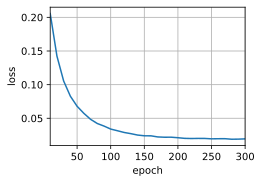

In [12]:
'''
模型维度：嵌入32维，GRU隐藏层32维
网络深度：2层GRU，dropout率0.1（防止过拟合）
数据格式：批量64，序列截断/填充至10个词
训练配置：学习率0.005，训练300轮，自动选择GPU/CPU
'''
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()
'''
train_iter：训练数据迭代器（每次返回(X, X_valid_len,Y,Y_valid_len)）
src_vocab：源语言词表（如英语）
tgt_vocab：目标语言词表（如法语）
效果：自动下载/加载机器翻译数据集（如WMT），构建词汇表，添加<bos>,<eos>,<pad>标记
'''
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
'''
编码器：len(src_vocab)→源语言词汇表大小（如10000）
解码器：len(tgt_vocab)→目标语言词汇表大小（可能不同）
封装：EncoderDecoder将编码器和解码器组合为完整Seq2Seq模型
参数传递：编码器的最终隐藏状态自动作为解码器初始状态
'''
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
'''
初始化：Xavier初始化所有权重
迭代训练：300轮循环
每轮batch处理：
X→源语言序列（含填充）
Y→目标语言序列（含填充）
dec_input=<bos>+Y[:-1]→Teacher Forcing输入
Y_hat=net(X,dec_input)→模型预测
loss(Y_hat,Y,Y_valid_len)→计算掩码损失
反向传播+梯度裁剪+Adam优化
监控：每10轮绘制损失曲线
输出：最终平均损失&训练速度（tokens/sec）
'''
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

预测

为什么需要enc_valid_len？<br>
编码器：使用 enc_valid_len 在GRU计算中忽略填充部分，确保state只由真实内容生成<br>
解码器init_state：虽然此处未直接使用enc_valid_len，但为支持更复杂的初始化（如注意力机制）预留接口<br>

状态传递的物理意义<br>
```
# 类比：编码器读完整个源句，形成"理解"（state）
# 解码器以这个"理解"为起点，开始逐词生成翻译
编码器状态 → [源句语义向量] → 解码器初始状态
```

In [13]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 1. 设置评估模式:关闭Dropout、BatchNorm等训练时特有的随机行为,确保输出确定性和可复现性
    net.eval()
    '''
    2. 源序列预处理
    1. 分词并转为索引
    src_sentence.lower().split(' ')：将输入转为小写并按空格分词→词元列表
    src_vocab[...]：将每个词元映射为词汇表中的整数索引
    +[src_vocab['<eos>']]：在末尾添加 结束符<eos>的索引
    '''
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    '''
    2. 记录有效长度
    作用：将序列的有效长度（含<eos>）记录为张量→(1,)
    必要性：告知编码器实际内容长度，以便在GRU计算中忽略填充部分
    '''
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    '''
    3. 截断或填充到固定长度
    若序列过长（>num_steps）： 截断保留前num_steps个词
    若序列过短（<num_steps）：用填充符<pad>补足到num_steps
    '''
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    '''
    4. 转为张量并添加batch维度
    torch.tensor(...,dtype=torch.long,device=device)：
    将Python列表转为PyTorch张量;指定类型torch.long（嵌入层要求的索引类型）;迁移到GPU/CPU
    torch.unsqueeze(...,dim=0)：
    在第0维增加一个维度，将形状从(seq_len,)→(1, seq_len)
    1表示batch size=1（预测时通常一次处理一个句子）
    最终enc_X形状：(1,num_steps)
    '''
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    '''
    3. 编码器前向传播
    1. 编码器前向传播
    输入：
    enc_X：源序列，形状(batch_size,num_steps);enc_valid_len：有效长度，形状(batch_size,)
    输出：enc_outputs是一个元组(output,state)
    output：编码器所有时间步的隐藏状态，形状 (num_steps,batch,num_hiddens)
    state：编码器最后时刻的隐藏状态，形状 (num_layers,batch,num_hiddens)
    '''
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    '''
    2. 初始化解码器状态
    dec_state=编码器的最终隐藏状态enc_outputs[1]
    形状保持：(num_layers,batch,num_hiddens)→(2,1,32)
    作用：将源序列的语义信息 完整传递给解码器作为初始记忆
    '''
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    '''
    4. 解码器初始输入
    BOS标记：创建仅含<bos>的初始输入;形状：(1,1)（batch=1,seq_len=1）
    tgt_vocab['<bos>']：获取"句子开始"标记的整数索引（例如 1）;[...]：将其包装为单元素列表[1]
    torch.tensor(...,dtype=torch.long,device=device)：
    转为PyTorch张量;类型为torch.long（嵌入层要求）;迁移到GPU/CPU;形状(1,)：一维张量
    torch.unsqueeze(...,dim=0)：
    在第0维增加维度，形状从(1,)→(1, 1)
    第一个 1：batch_size=1（单句预测）
    第二个 1：当前序列长度=1（仅含<bos>）
    '''
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    '''
    output_seq：空列表，用于累积预测的token索引（如[5,10,7]）
    attention_weight_seq：空列表，用于存储每个时间步的注意力权重矩阵（用于可视化）
    核心作用：自回归生成的起点
    这两行是循环解码的初始化：
    dec_X：初始输入仅为<bos>标记，后续循环中被上一步的预测结果替换
    output_seq：逐步收集所有预测，最终转换为完整句子
    '''
    output_seq, attention_weight_seq = [], []
    '''
    5. 自回归解码循环
    解码：Y 形状 (1,1,vocab_size)，是当前时间步的预测分布
    贪心采样：argmax(dim=2)在词汇表维度取最大值索引→dec_X形状(1,1)
    提取token：squeeze 去掉batch维，item()转为Python整数
    存储注意力：可选保存每层/每头的注意力权重（用于可视化）
    终止判断：生成EOS则跳出循环
    记录结果：将预测词索引加入输出序列
    '''
    for _ in range(num_steps): # 最多生成num_steps个词
        '''
        单步解码
        输入：dec_X：当前时间步的输入词索引，形状(1,1)(batch,seq_len);dec_state：解码器上一时刻的隐藏状态
        输出：Y：当前时间步的预测分布，形状(1,1,vocab_size);dec_state：更新后的隐藏状态，供下一步使用
        '''
        Y, dec_state = net.decoder(dec_X, dec_state)
        '''
        2. 贪心选择概率最高的词
        Y.argmax(dim=2)：在词汇表维度（vocab_size）取最大值的索引
        结果：预测词的索引，形状(1,1) ，作为下一步的输入
        '''
        dec_X = Y.argmax(dim=2)
        # 3. 提取Python整数:压缩batch维：(1,1)→(1,)→再转为标量;类型转换：转为Python int，便于后续判断和存储
        # item()将只含单个元素的张量转换为Python原生标量 
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 4. 保存注意力权重:条件：若设置保存标志，记录当前步的注意力分布;用途：可视化对齐关系（源词→目标词）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights) # 保存注意力权重
        # 5. 终止判断:提前终止：一旦生成结束符<eos>，立即停止循环;效率：避免继续生成无意义的填充词
        if pred == tgt_vocab['<eos>']:
            break # 遇到EOS终止生成
        # 6. 存储预测结果:累积：将当前预测词索引加入输出列表;最终：output_seq=[5,10,7,...]
        output_seq.append(pred)
    '''
    tgt_vocab.to_tokens(output_seq)：将索引列表转为词元列表
    [5,10,7]→['bonjour','monde','!']
    ' '.join(...)：用空格连接为完整句子
    返回：(翻译结果, 注意力权重列表)
    '''
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

BLEU的代码实现<br>
$e^{(min(0,1-\frac{len_{label}}{len_{label}}))\prod_{n=1}^{k}p_{n}^{\frac{1}{2^n} }  }$<br>

In [14]:
def bleu(pred_seq, label_seq, k):  
    """计算BLEU"""
    # 1. 预处理序列:分词：将预测和标签字符串按空格分割为词元列表;计算长度：获取两个序列的词数
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    '''
    2. 长度惩罚项（Brevity Penalty）
    目的：惩罚过短的预测（机器翻译中常见的"偷懒"行为）
    若len_pred<len_label（预测更短）：1-len_label/len_pred为负，惩罚生效
    若len_pred>=len_label：惩罚为0，指数后为1（无惩罚）
    标签 "a b c"（3词），预测 "a b"（2词）：exp(1-3/2) = exp(-0.5) ≈ 0.61
    标签 "a b c"（3词），预测 "a b c d"（4词）：exp(0) = 1
    '''
    score = math.exp(min(0, 1 - len_label / len_pred))
    # 3. n-gram精度计算
    for n in range(1, k + 1): # 遍历1-gram到k-gram
        num_matches, label_subs = 0, collections.defaultdict(int)
        # 构建标签n-gram字典:滑动窗口：在标签序列上提取所有n-gram（连续n个词）;统计频次：记录每个n-gram出现次数
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        # 统计预测n-gram匹配数
        for i in range(len_pred - n + 1):
            '''
            精确匹配：预测n-gram必须在标签n-gram字典中存在
            截断计数：每个标签n-gram最多被匹配其出现次数次
            示例（标签"a b a"，预测"a a b"）：
            n=1：匹配'a'两次，'b'一次 → num_matches=3（正确）
            若无截断机制：预测的两个'a'会错误匹配标签的一个'a'两次
            遍历标签 "a b a"：
            i=0: label_subs['a'] = 1
            i=1: label_subs['b'] = 1
            i=2: label_subs['a'] = 2（累加）
            '''
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0: # 若该n-gram在标签中存在且未耗尽
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1 # 消耗一次匹配机会（防止重复计数）
        '''
        4. 计算加权n-gram精度
        分子：num_matches（正确预测的n-gram数）
        分母：len_pred - n + 1（预测序列中n-gram总数）
        权重：math.pow(0.5, n)，高阶n-gram权重指数衰减
        1-gram权重：0.5²=0.5;2-gram权重：0.5²=0.25;3-gram权重：0.5³=0.125
        几何平均：各阶精度相乘，避免某一阶主导
        整体公式:BLEU=BP×exp(Σₖwₙ×log(Pₙ))
        其中：
        BP：长度惩罚项;Pₙ：n-gram精度（正确数/预测总数）;wₙ=0.5ⁿ
        '''
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

将几个英语句子翻译成法语

In [15]:
'''
1. 取英语句子 "he's calm ."
   ↓
2. 编码器编码为上下文向量
   ↓
3. 解码器自回归生成 "il est calme ."
   ↓
4. 与参考译文 "il est calme ." 对比
   ↓
5. BLEU计算：n-gram匹配率 + 长度惩罚
   ↓
6. 输出: he's calm . => il est calme ., bleu 1.000
engs：4个英语句子（源语言），包含标点符号和缩写
fras：4个对应的法语参考译文（目标语言），作为评估标准
'''
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    '''
    translation：模型生成的法语译文（如 "va !"）
    attention_weight_seq：注意力权重序列（用于可视化对齐）
    translation：模型的预测输出
    fra：人工参考译文（ground truth）
    k=2：计算到2-gram（BLEU-2），衡量词对的匹配程度
    返回值：0~1之间的分数，越高说明翻译质量越好
    '''
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va , maintenant . recul, bleu 0.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => <unk> <unk> <unk> ., bleu 0.000
i'm home . => je suis chez moi retard ., bleu 0.803
